In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [54]:
df = pd.read_csv('data/data.csv')[:1000]
df.head()

UPDATE_TIME  HOUR_ID ZONE_CODE        SERVER_NAME  BANDWIDTH_TOTAL  MAX_USER
0  2017-10-01        0    ZONE01  SERVER_ZONE01_001        26.906932     612.0
1  2017-10-01        0    ZONE01  SERVER_ZONE01_002        61.481693     561.0
2  2017-10-01        0    ZONE01  SERVER_ZONE01_003        20.609837     969.0
3  2017-10-01        0    ZONE01  SERVER_ZONE01_004        97.737384    1377.0
4  2017-10-01        0    ZONE01  SERVER_ZONE01_005       113.250685    1887.0

In [55]:
data = df[['UPDATE_TIME', 'BANDWIDTH_TOTAL', 'MAX_USER']].T
data  = pd.DataFrame(data.values[1:], columns=data.iloc[0])
data.head()

UPDATE_TIME 2017-10-01 2017-10-01 2017-10-01 2017-10-01 2017-10-01 2017-10-01  \
0              26.9069    61.4817    20.6098    97.7374    113.251    112.607   
1                  612        561        969       1377       1887       1887   

UPDATE_TIME 2017-10-01 2017-10-01 2017-10-01 2017-10-01  ... 2017-10-01  \
0              8.13378    36.0548    57.5135    50.0268  ...    1.35977   
1                  663        612        663       1020  ...        408   

UPDATE_TIME 2017-10-01 2017-10-01 2017-10-01 2017-10-01 2017-10-01 2017-10-01  \
0              1.25411   0.120433     5.7913   0.179095    1.92971   0.542538   
1                  255        255        408        357        612        153   

UPDATE_TIME 2017-10-01 2017-10-01 2017-10-01  
0              1.08452  0.0842373   0.969835  
1                  255        255        357  

[2 rows x 1000 columns]

In [56]:
data_start_date = data.columns[1]
data_end_date = data.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2017-10-01 to 2017-10-01


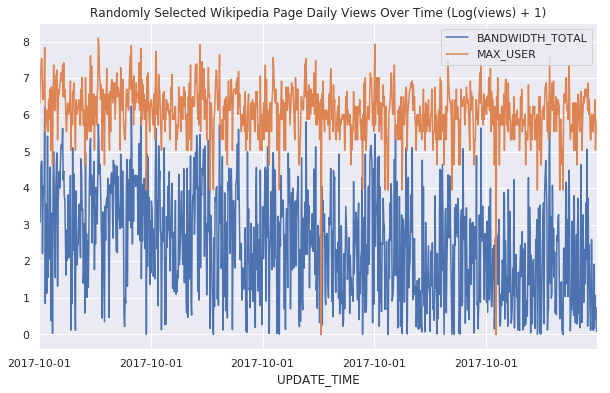

In [57]:
def plot_random_series(data, n_series):
    
    sample = data.sample(n_series, random_state=8)
    page_labels = ['BANDWIDTH_TOTAL', 'MAX_USER']
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(data, 2)

In [58]:
from datetime import timedelta

pred_steps = 60 
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [59]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [60]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2017-10-01 00:00:00 - 2017-06-03 00:00:00
Train prediction: 2017-06-04 00:00:00 - 2017-08-02 00:00:00 

Val encoding: 2017-11-30 00:00:00 - 2017-08-02 00:00:00
Val prediction: 2017-08-03 00:00:00 - 2017-10-01 00:00:00

Encoding interval: -119
Prediction interval: 60


In [61]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in data.columns[1:]]),
                          data=[i for i in range(len(data.columns[1:]))])

series_array = data[data.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [62]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':60})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
conv1d_133 (Conv1D)             (None, None, 16)     32          input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_134 (Conv1D)             (None, None, 32)     1056        conv1d_133[0][0]                 
__________________________________________________________________________________________________
conv1d_135 (Conv1D)             (None, None, 32)     1056        conv1d_133[0][0]                 
__________________________________________________________________________________________________
activation

In [63]:
first_n_samples = 120000
batch_size = 2**11
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

/home/anhbn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  


ZeroDivisionError: division by zero

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [ ]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [ ]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])


In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=16534, enc_tail_len=100)

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=16555, enc_tail_len=100)

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=4000, enc_tail_len=100)

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=68000, enc_tail_len=100)

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=6007, enc_tail_len=100)

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=70450, enc_tail_len=100)

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=16551, enc_tail_len=100)